### ECG RNN Age Model

In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import xgboost as xgb 
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import os
import scipy.io as sio

In [2]:
sr = 100
quick_load = True

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [4]:
if(quick_load):
    X = np.load('../data/X_raw.npy')
    Y = pd.read_csv('../data/Y_raw.csv')
else:
    X,Y = load_data()

In [5]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [6]:

with tf.device('/GPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [7]:

with tf.device('/GPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].age

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].age

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89) & (y_train >= 18)] # Additional filtering of patients older than 89 and younger than 18
        ry_train = y_train[(y_train < 89) & (y_train >= 18)]

        rX_val = X_val[(y_val < 89) & (y_val >= 18)]
        ry_val = y_val[(y_val < 89) & (y_val >= 18)]

        rX_test = X_test[(y_test < 89) & (y_test >= 18)]
        ry_test = y_test[(y_test < 89) & (y_test >= 18)]

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return rX_train, ry_train, rX_val, ry_val, rX_test, ry_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


In [8]:
def data_subsetting(X, Y):

        Y_filtered = Y.age
        Y_filtered = Y_filtered.to_numpy()

        X_filtered = X[(Y_filtered < 89) & (Y_filtered >= 18)] # Additional filtering of patients older than 89 and younger than 18
        Y_filtered = Y_filtered[(Y_filtered < 89) & (Y_filtered >= 18)]
        Y_filtered_full = Y[(Y.age < 89) & (Y.age >= 18)]

        return X_filtered, Y_filtered, Y_filtered_full

X_filtered, Y_filtered, Y_filtered_full = data_subsetting(X_final, Y)

In [9]:
X_filtered.shape, Y_filtered.shape, Y_filtered_full.shape, (X_train.shape[0] + X_val.shape[0] + X_test.shape[0])

((21275, 1000, 12), (21275,), (21275, 28), 21275)

### Checkpoint Callback

In [10]:
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(SaveModelCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss', None)
        if val_loss is not None and val_loss <= self.threshold:
            # Save model weights
            mod_name = f'age_model: {val_loss:.4f}.h5'
            model_path = os.path.join("../saved_models/100hz/age_models/", mod_name)
            self.model.save_weights(f"../saved_models/100hz/age_models/age_model:{val_loss:.4f}.h5")
            print(f'age_model: {val_loss:.4f}')
        elif val_loss is None:
            print("Validation loss is not available. Check if the validation data is provided and 'val_loss' is being computed.")

### Classical CNN Model

In [11]:
cnn_age_model = tf.keras.models.load_model("../saved_models/100hz/age_models/model_1.h5", compile = False)
cnn_age_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss = 'mean_absolute_error',
                      metrics=['mae'])

### CNN and LSTM Model

In [12]:
with tf.device('/GPU:0'):
    # Batching
    batch_size = 64   # Batch size determines the amount of data processed each round
    num_epochs = 50   # All of the data is processed a certain number of time repetedly. Based on the number of epochs. 
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))   # Grouping the X and Y together. Similar to zipping

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(X_train))   # We are able to shuffle both the X and Y the same because they are grouped. 
    dataset = dataset.batch(batch_size)    # The input data is split into the batch size


    # Creating the model
    cnn_rnn_age_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
        tf.keras.layers.Dropout(0.2, seed = 13),

        tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.GlobalAveragePooling1D(),  # Global Average Pooling

        tf.keras.layers.RepeatVector(3),  # Prepares the input shape for LSTM after Global Pooling

        # Using Bidirectional LSTM and additional LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.BatchNormalization(),

        # Flattening the output to feed into a Dense layer
        tf.keras.layers.Flatten(),

        # Existing Dense Layers
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='linear')
    ])


    # Compiling the model
    cnn_rnn_age_model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                        metrics = ['mse'])


    # Learning rate scheduler
    peak_saver = SaveModelCallback(threshold = 8.0)

    # Fitting the model
    cnn_rnn_history = cnn_rnn_age_model.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val), callbacks=peak_saver)

Epoch 1/50
266/266 [==============================] - 12s 23ms/step - loss: 20.1816 - mse: 733.3819 - val_loss: 14.0934 - val_mse: 297.4942
Epoch 2/50
266/266 [==============================] - 5s 20ms/step - loss: 11.5929 - mse: 215.3098 - val_loss: 9.6596 - val_mse: 148.4518
Epoch 3/50
266/266 [==============================] - 6s 22ms/step - loss: 10.7807 - mse: 188.3375 - val_loss: 9.0871 - val_mse: 132.3480
Epoch 4/50
266/266 [==============================] - 6s 22ms/step - loss: 10.5213 - mse: 180.4511 - val_loss: 9.4268 - val_mse: 142.4589
Epoch 5/50
266/266 [==============================] - 6s 22ms/step - loss: 10.0921 - mse: 165.6082 - val_loss: 8.8114 - val_mse: 124.3956
Epoch 6/50
266/266 [==============================] - 6s 22ms/step - loss: 9.7751 - mse: 155.4229 - val_loss: 8.8401 - val_mse: 127.4375
Epoch 7/50
266/266 [==============================] - 6s 22ms/step - loss: 9.4874 - mse: 146.3270 - val_loss: 9.0330 - val_mse: 134.0062
Epoch 8/50
266/266 [==============

In [13]:
import tensorflow as tf

with tf.device('/GPU:0'):
    # Define Input Layer
    input_layer = tf.keras.Input(shape=(1000, 12))

    # CNN Part
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=8, strides=4, padding="valid", activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=3, strides=1, padding="valid")(x)

    x = tf.keras.layers.Conv1D(filters=48, kernel_size=6, strides=3, padding="valid", activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding="valid")(x)

    x = tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=2, padding="valid", activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=3, strides=1, padding="valid")(x)

    x = tf.keras.layers.Conv1D(filters=96, kernel_size=3, strides=1, padding="valid", activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding="valid")(x)

    # Reshaping before passing to RNN
    x = tf.keras.layers.Reshape((997, 96))(x)

    # RNN Part
    x = tf.keras.layers.LSTM(units=32, return_sequences=True, activation='tanh', bias_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Flatten and Dense layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output_layer = tf.keras.layers.Dense(1, activation='linear')(x)



    # # Build the Model
    # cnn_rnn_age_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # # Compile the Model
    # cnn_rnn_age_model.compile(
    #     loss=tf.keras.losses.mae,
    #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #     metrics=['mse']
    # )

    # # Create a Dataset
    # batch_size = 64
    # num_epochs = 25
    # dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    # dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

    # peak_saver = SaveModelCallback(threshold = 8.05)

    # # Fit the Model
    # cnn_rnn_history = cnn_rnn_age_model.fit(
    #     dataset, 
    #     epochs=num_epochs, 
    #     validation_data=(X_val, y_val), 
    #     callbacks=[peak_saver]
    # )


In [14]:
cnn_rnn_age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 249, 32)           3104      
                                                                 
 batch_normalization (BatchN  (None, 249, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 48)            9264      
                                                                 
 batch_normalization_1 (Batc  (None, 81, 48)           192       
 hNormalization)                                                 
                                                        

### Gradient Booster

In [15]:
# rnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")

def apply_boost_regression(model, layer_name, X, y, xgb_weight = 0.5):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    # Extracting the features from the LSTM layer
    X_features = feature_extraction_model.predict(X)

    # XGBoost for regression
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_features, y)

    xgb_preds = np.squeeze(xgb_model.predict(X_features))
    model_preds = np.squeeze(model.predict(X))
    

    print(model_preds.shape)
    print(xgb_preds.shape)
    # combined_preds = list()
    # for i in xgb_preds:
    #     combined_preds[i] = xgb_preds[i] + model_preds[i]

    combined_preds = (xgb_preds + model_preds)/2

    return xgb_preds


### Blocking

In [16]:
# Function to bin the age values into age blocks
def bin_age(age):
    if age <18:
        return '<18'
    elif age >= 18 and age <= 25:
        return '18-25'
    elif age > 25 and age <= 49:
        return '25-49'
    elif age > 49 and age <= 75:
        return '50-75'
    else:
        return '75+'

### Evalutating the Model

In [38]:
def predict_set(model, X):
    predicted_age = model(tf.convert_to_tensor(X))
    return predicted_age

In [39]:
with tf.device("/CPU:0"):
    predict_set(cnn_rnn_age_model, X_test)

In [60]:
with tf.device('/CPU:0'):
    predicted_age = apply_boost_regression(cnn_rnn_age_model, 'flatten', X_filtered, tf.cast(Y_filtered, dtype=tf.int32))

665/665 [==============================] - 4s 6ms/step
(21275,)
(21275,)


In [61]:
age_actual_blocked = np.array([bin_age(age) for age in Y_filtered])
age_pred_blocked = np.array([bin_age(age) for age in predicted_age])

In [62]:
predicted_age

array([56.404552, 21.643139, 37.58863 , ..., 59.807682, 74.183174,
       58.951294], dtype=float32)

### Model Evaluation

In [63]:
import seaborn as sns   # Remeber to install seaborn

def age_bar(actual, predicted, title):
    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data

    # Create a group boxplot using seaborn
    plt.figure(figsize=(34, 13))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced
    category_positions = range(len(data['Category'].unique()))
    plt.scatter(category_positions, np.unique(np.squeeze(actual)), color='black', label='Scatter Plot', alpha = 0.7)   # The true line represents what the predicted age should be. 
    plt.xlabel('Actual Age', fontsize = 18)
    plt.ylabel('Predicted Age', fontsize = 18)
    plt.xticks(fontsize=11) 
    plt.yticks(range(0, 135, 5), fontsize=11)
    plt.title(title, fontsize = 21)
    plt.show()

In [64]:
def age_categorizer(actual, predicted, Y, title, category_column):
    unique_categories = Y[category_column].unique()

    for category_value in unique_categories:
        predicted_category = predicted[Y[category_column] == category_value]
        actual_category = actual[Y[category_column] == category_value]

        age_bar(actual_category, predicted_category, title=f'{title} - {category_value}')

In [65]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes else np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix On Testing Dataset",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.set_xlabel("Predicted label", fontsize=text_size)
    ax.set_ylabel("True label", fontsize=text_size)
    ax.set_title("Confusion Matrix", fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), repeat=2):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()


In [66]:
def age_cf(actual_blocks, predicted_blocks):
    # Compute the confusion matrix
    cm = confusion_matrix(actual_blocks, predicted_blocks, labels=['18-25', '25-49', '50-75', '75+'])

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap of the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['18-25', '25-49', '50-75', '75+'], yticklabels=['18-25', '25-49', '50-75', '75+'])
    plt.xlabel('Predicted Age Block')
    plt.ylabel('Actual Age Block')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [67]:
import seaborn as sns   # Remeber to install seaborn

def cat_plot(actual, predicted):
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data
    sns.catplot(x='Category', y='Values', data=data, order=['18-25', '25-49', '50-75', '75+'])   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced

In [68]:
def category_boxplot(categories, values, title, xlabel='Age Group', ylabel='Age Predictions', category_order=None):
    data = pd.DataFrame({xlabel: categories, ylabel: values})
    
    if category_order:
        data[xlabel] = pd.Categorical(data[xlabel], categories=category_order, ordered=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=xlabel, y=ylabel, data=data, width=0.6, order=category_order)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize =20)

    # Show the plot
    plt.show()

In [69]:
Y_filtered_full.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

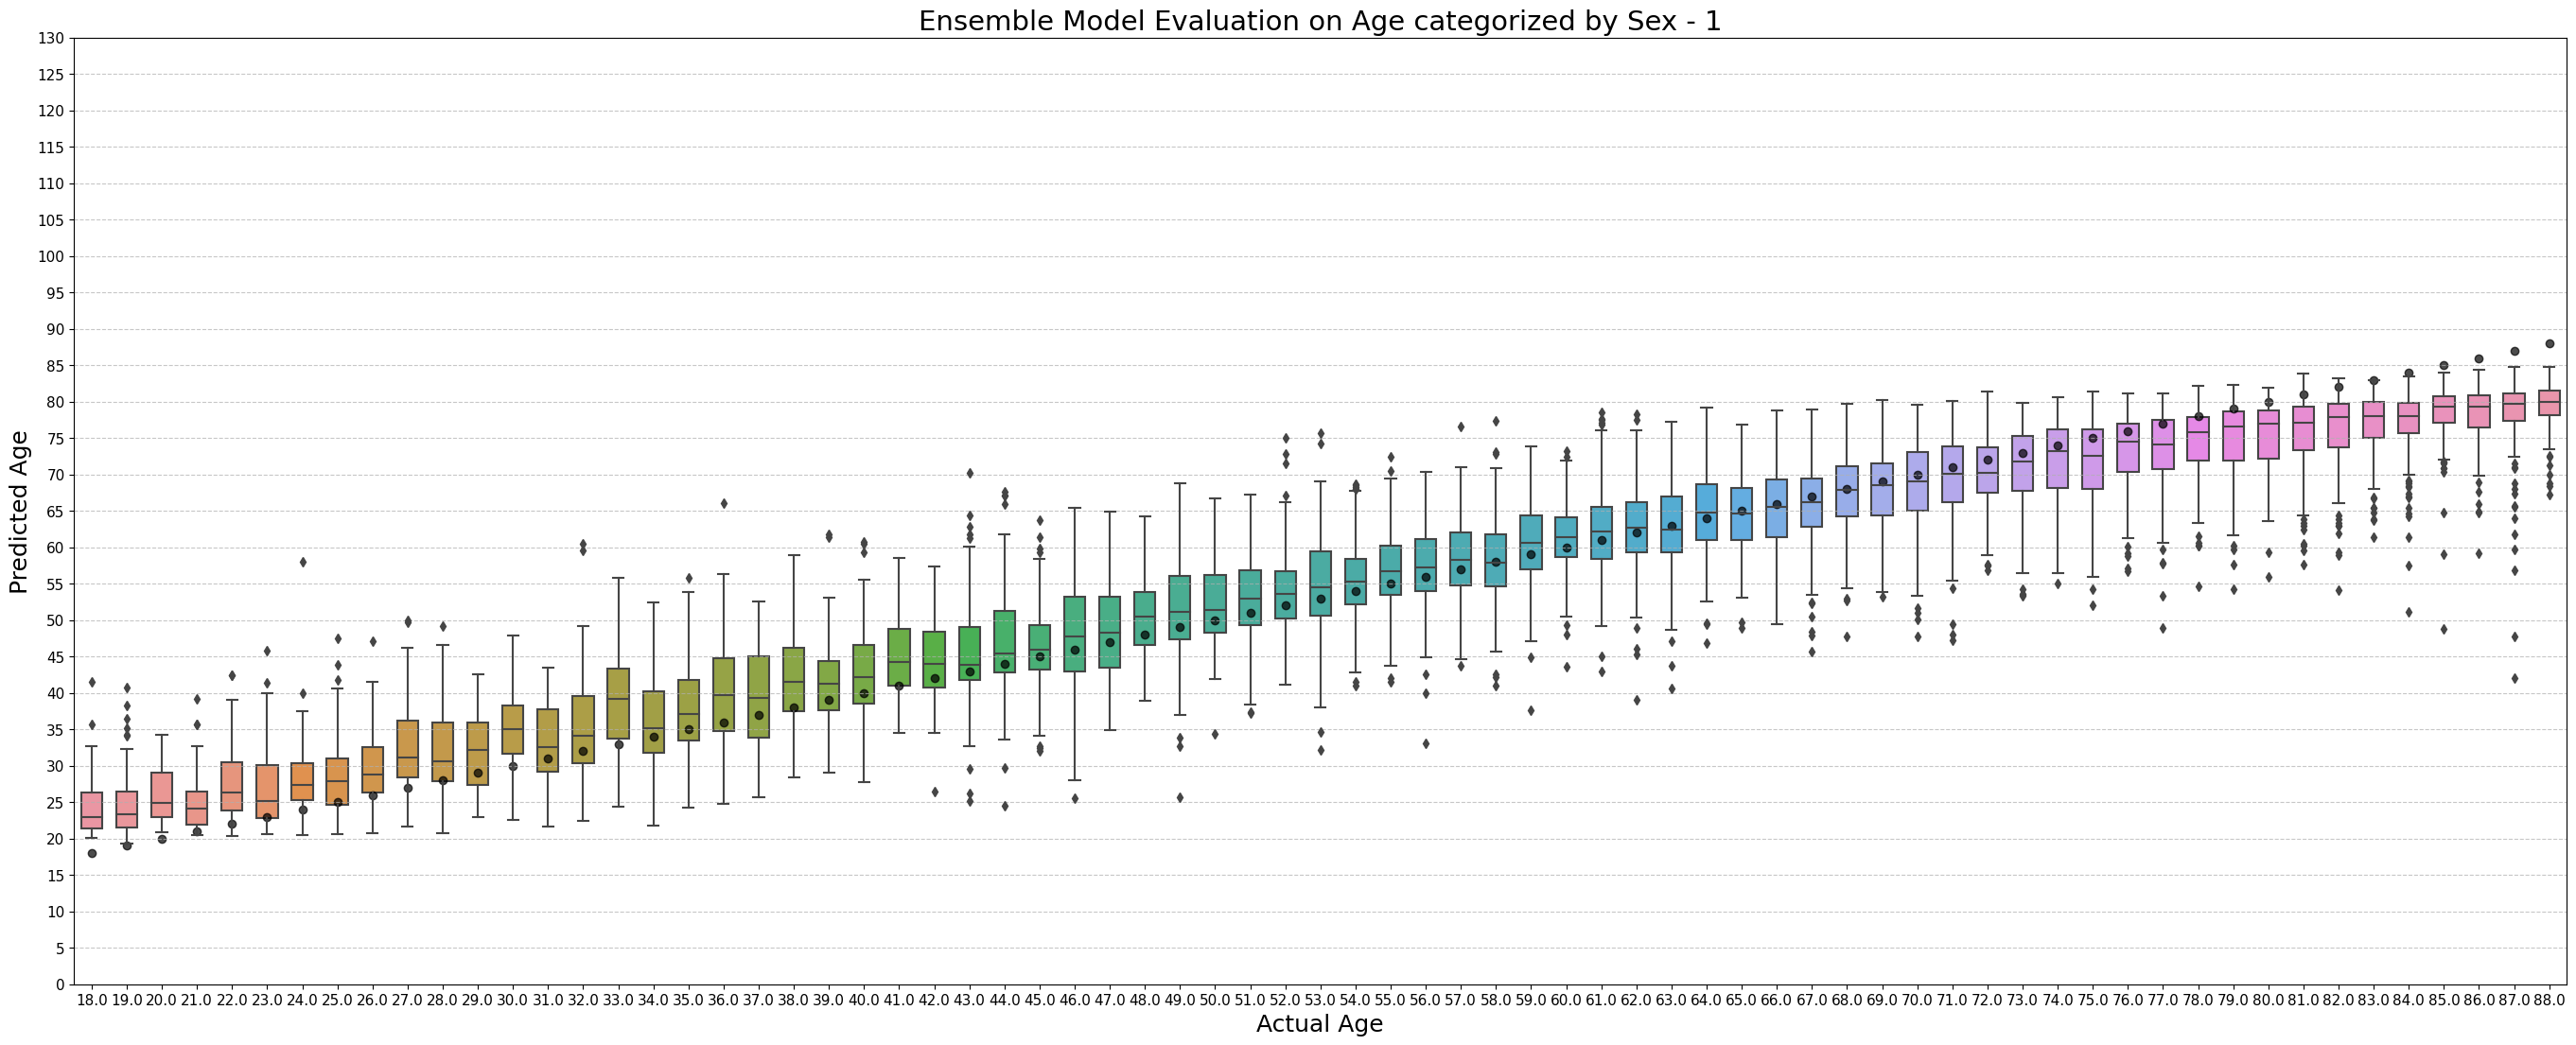

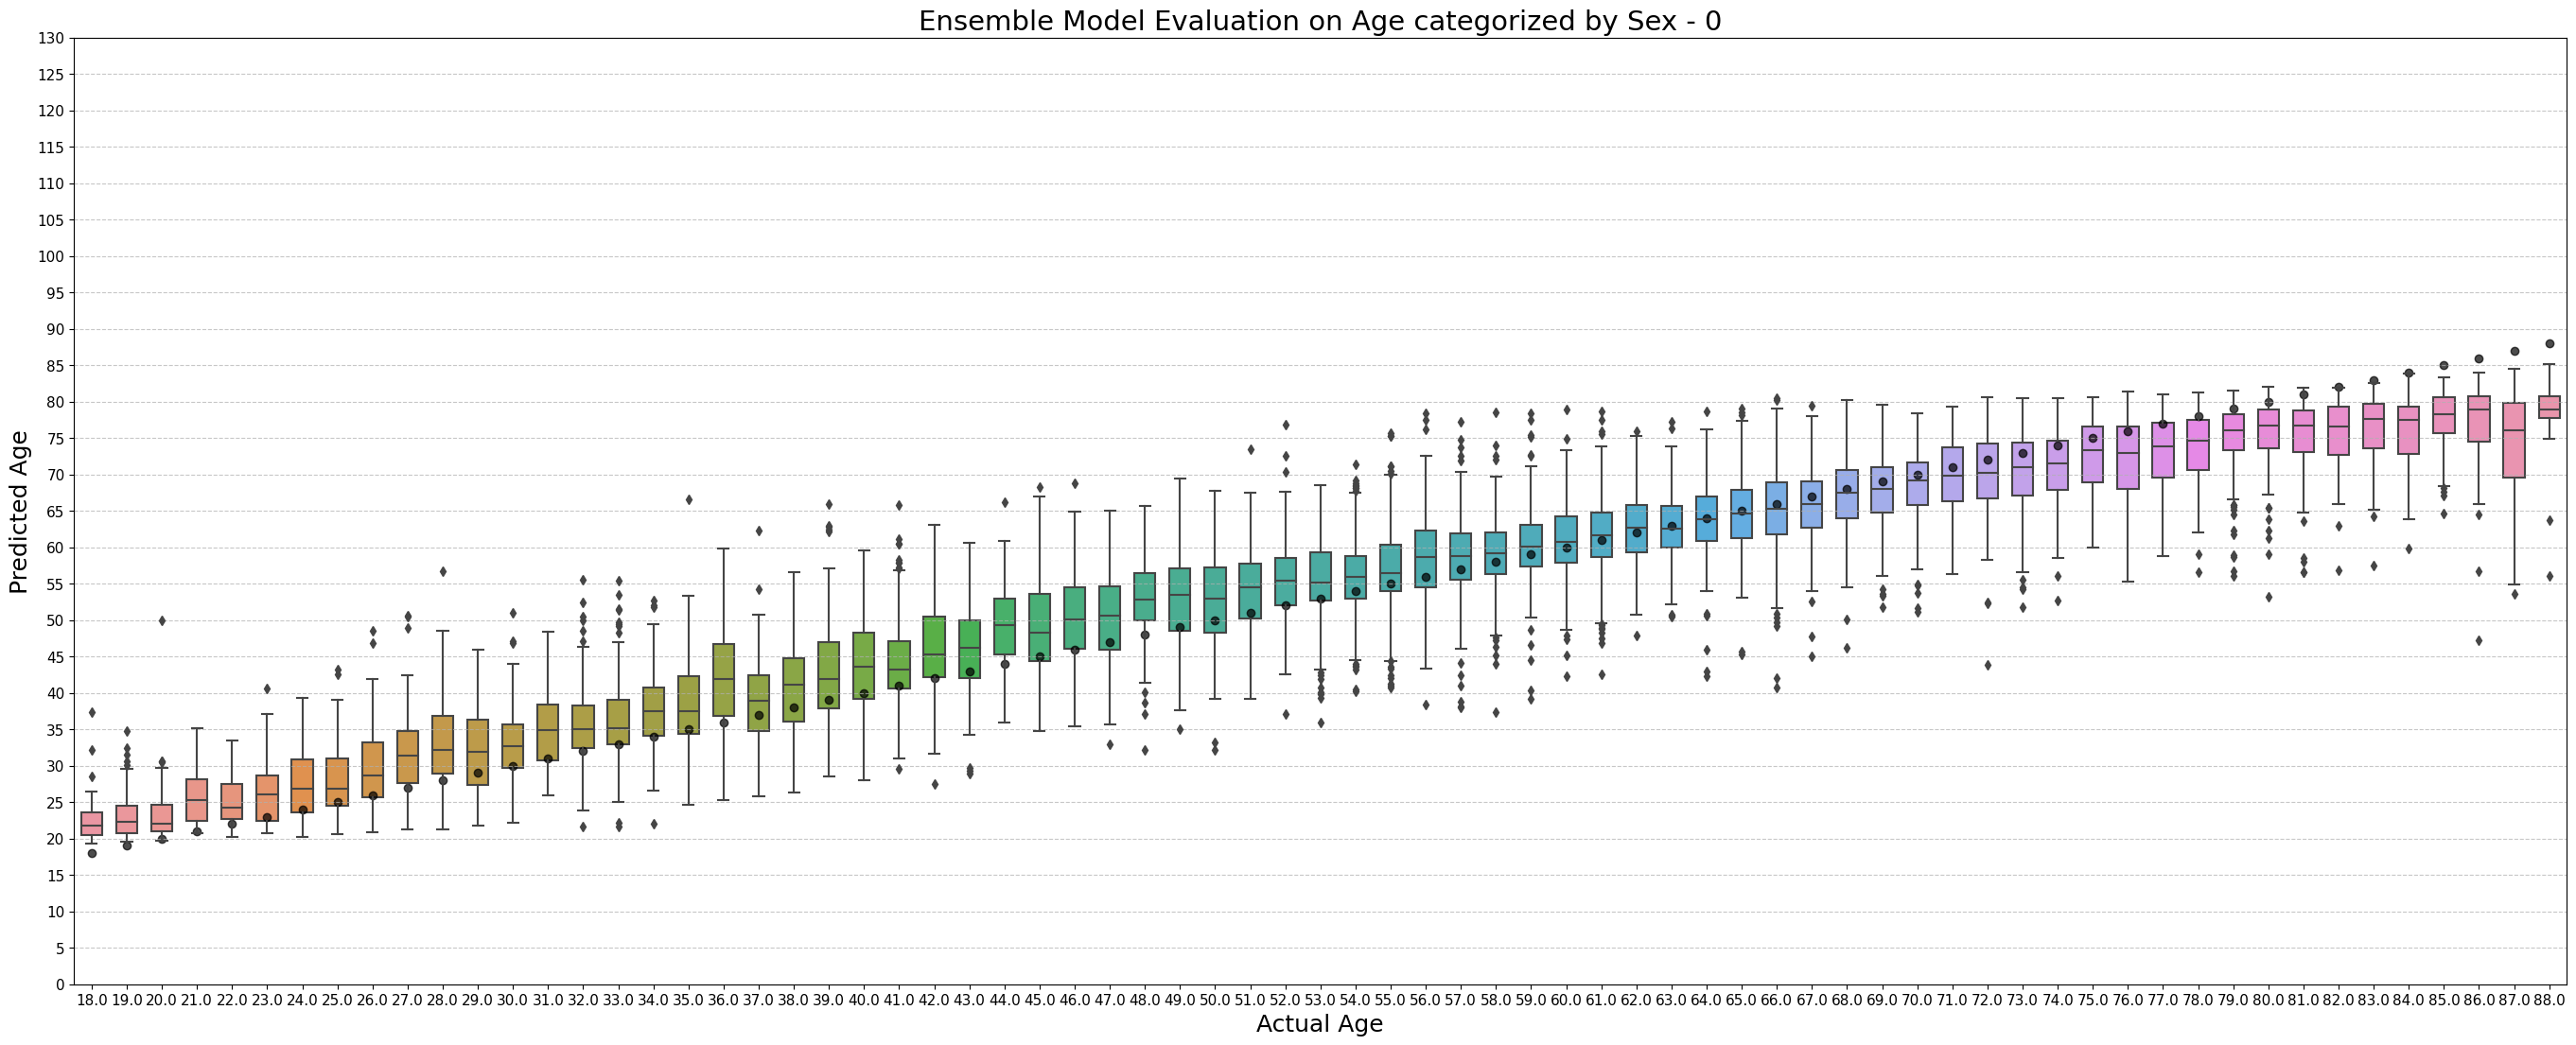

In [70]:
age_categorizer(Y_filtered, predicted_age, Y_filtered_full, title = "Ensemble Model Evaluation on Age categorized by Sex", category_column = "sex")

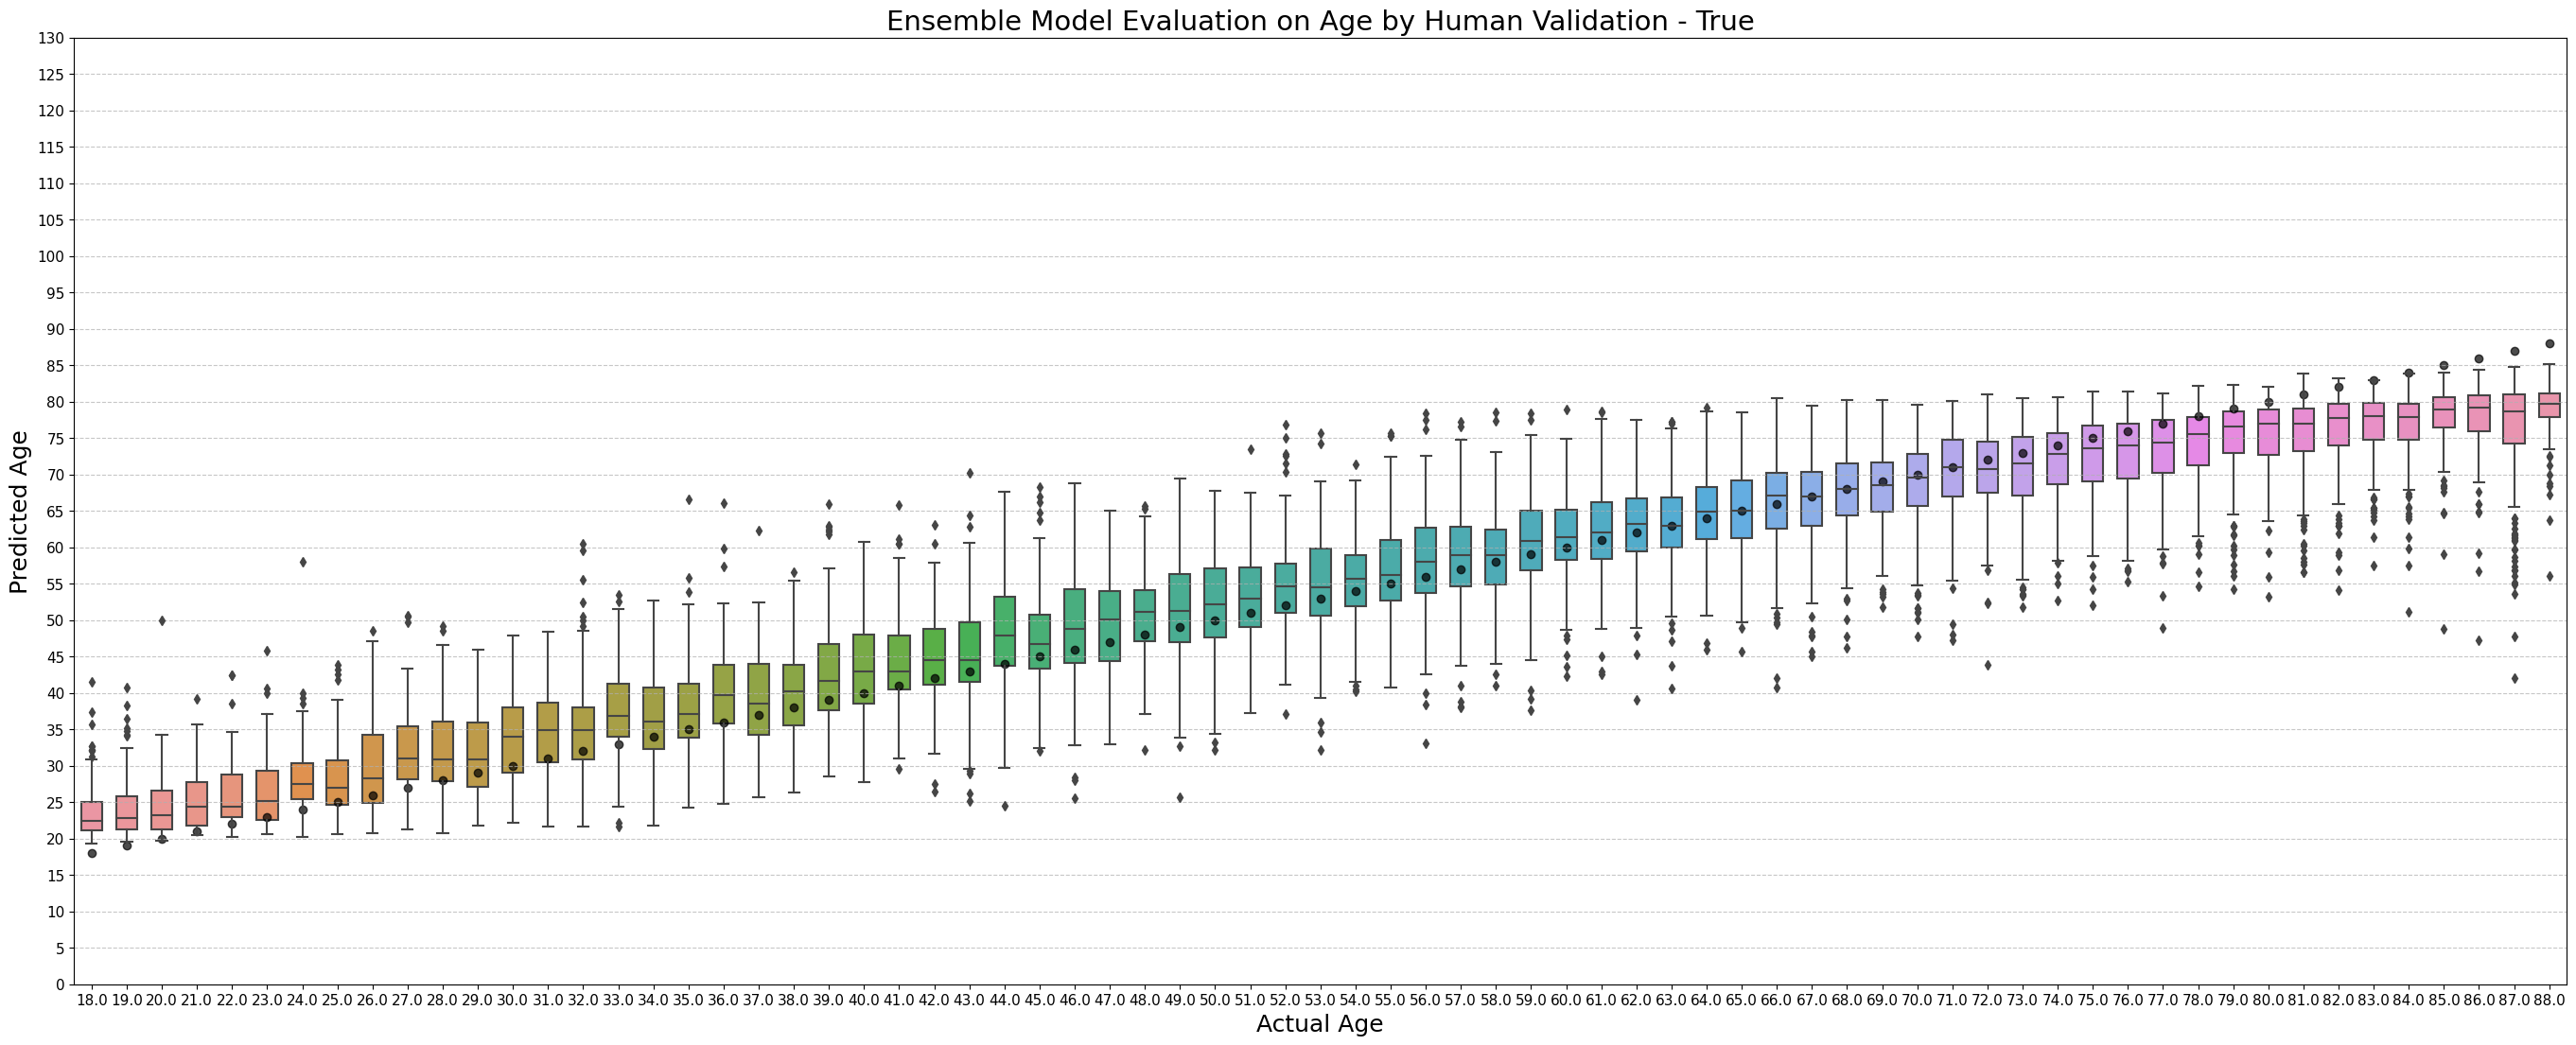

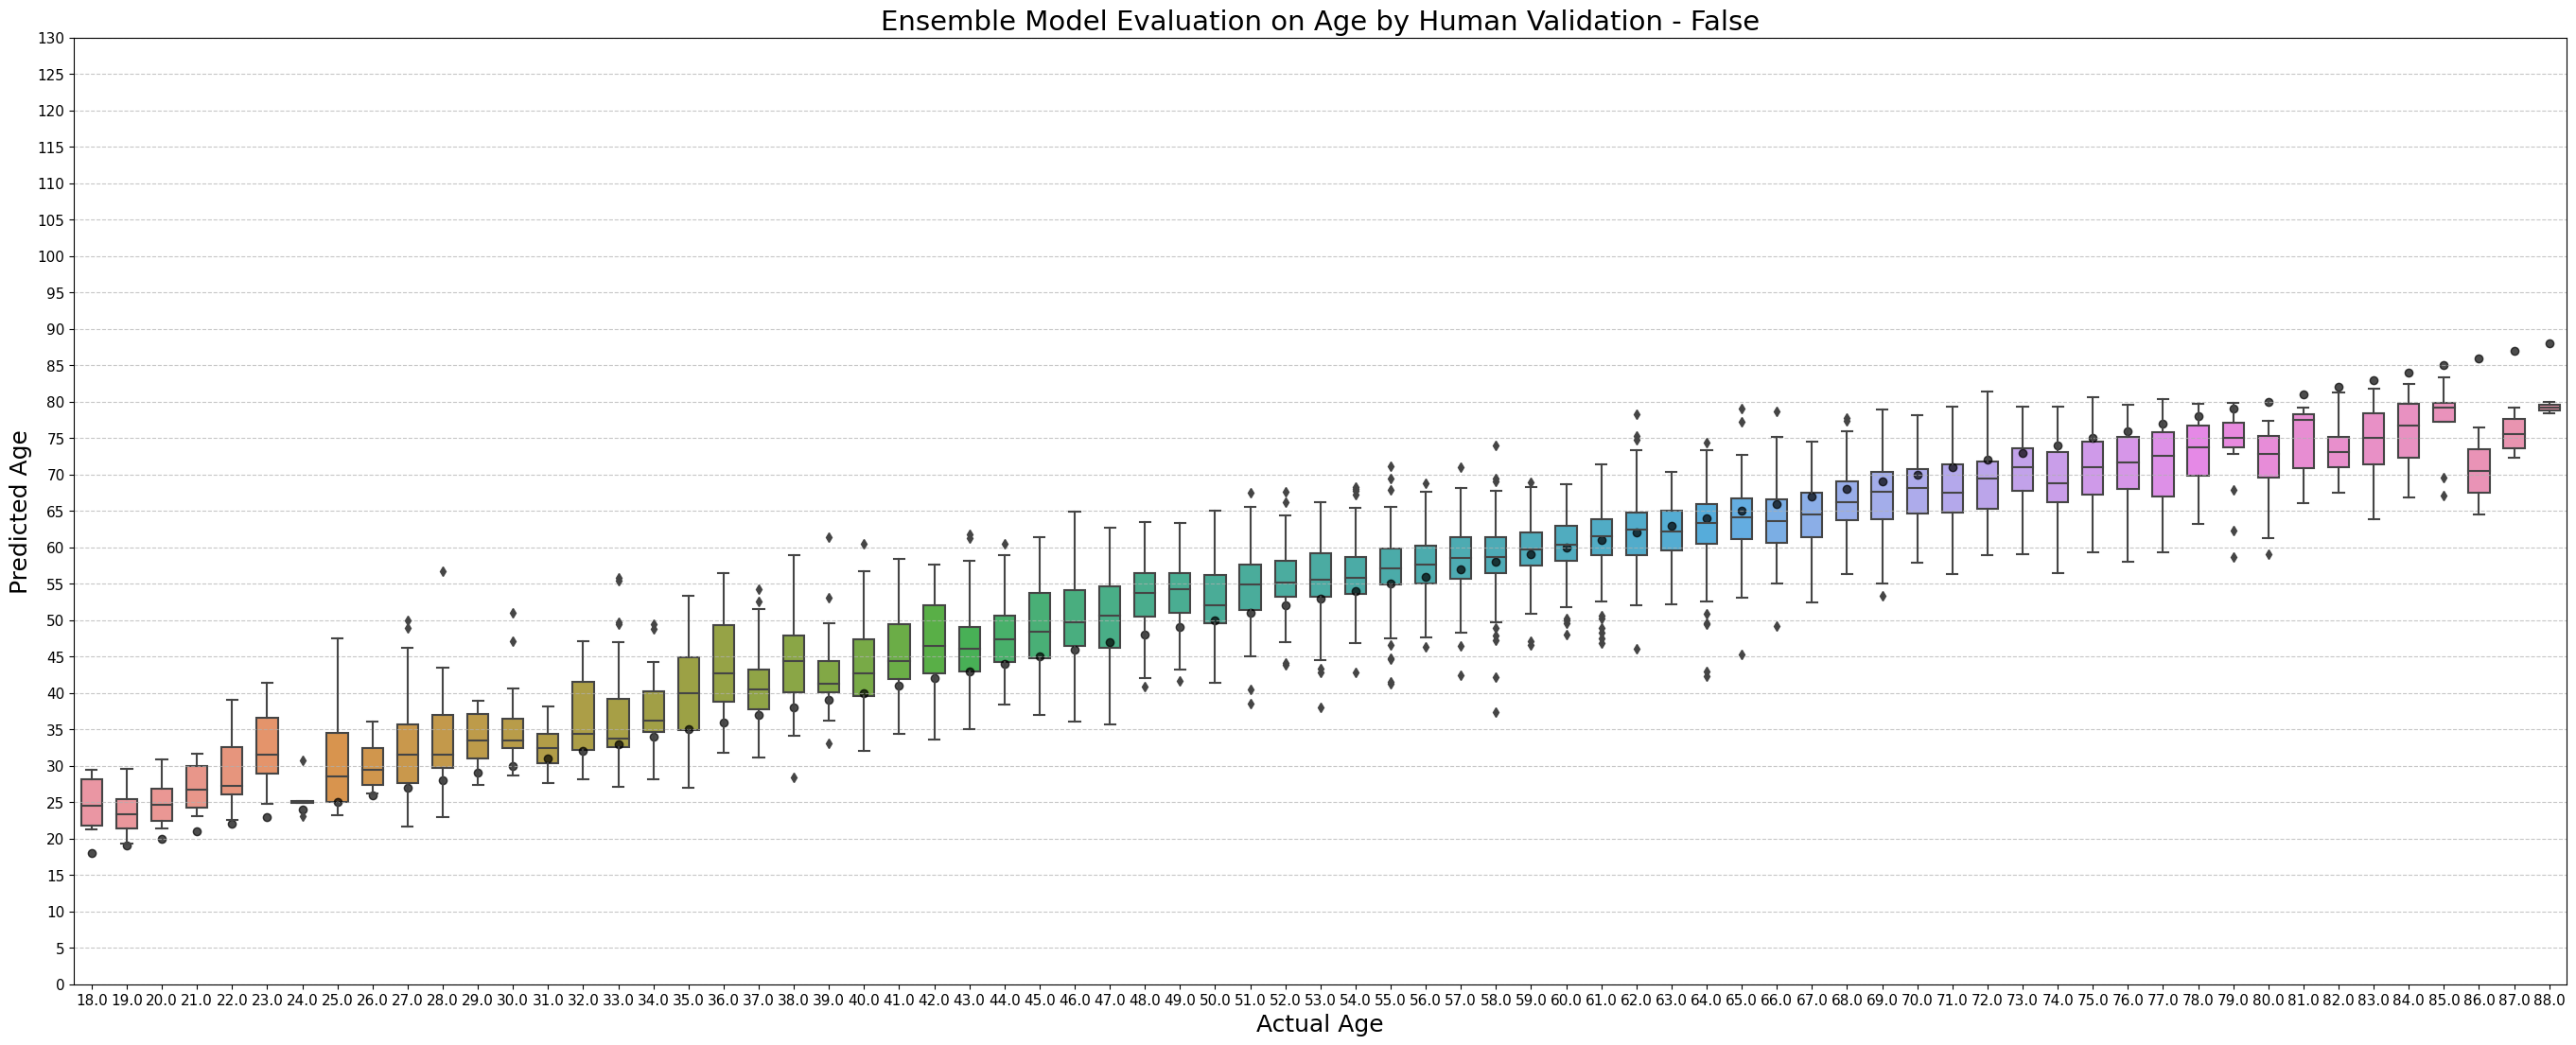

In [71]:
age_categorizer(Y_filtered, predicted_age, Y_filtered_full, title = "Ensemble Model Evaluation on Age by Human Validation", category_column = "validated_by_human")

### Age Confusion Matrix

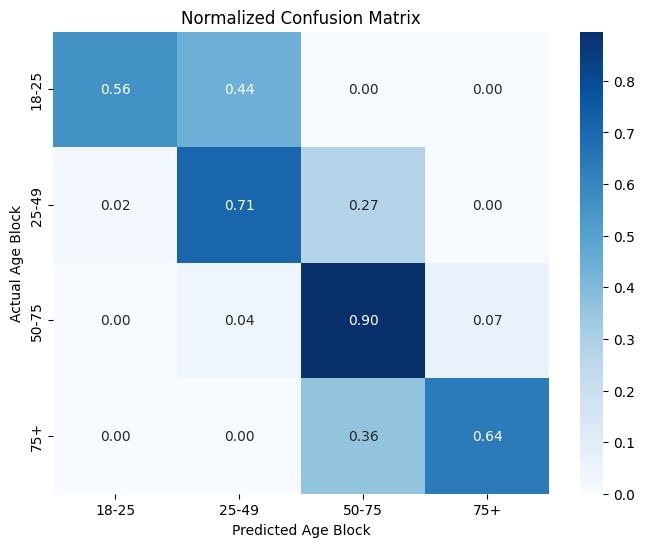

In [72]:
age_cf(age_actual_blocked, age_pred_blocked)

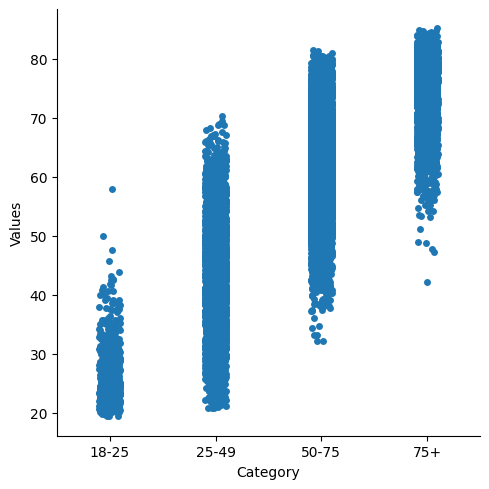

In [73]:
cat_plot(age_actual_blocked, predicted_age)

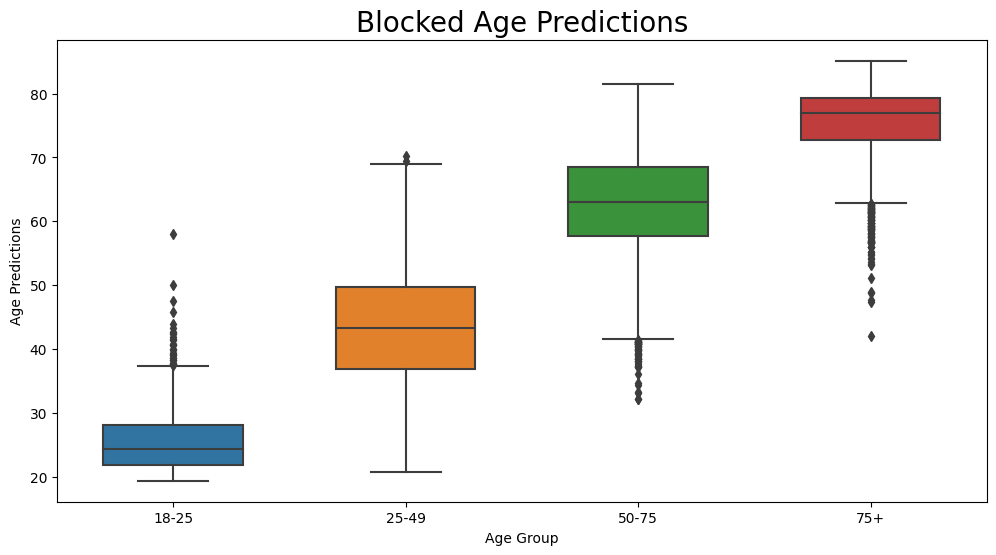

In [74]:
category_boxplot(age_actual_blocked, predicted_age, title = "Blocked Age Predictions", category_order = ['18-25', '25-49', '50-75', '75+'])

### MAE Metric

In [75]:
from sklearn.metrics import mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

mean_absolute_error(Y_filtered, predicted_age), mean_squared_error(Y_filtered, predicted_age)**0.5

(4.970910061433929, 6.533677396323682)

### R-Squared

In [76]:
from sklearn.metrics import r2_score
r2_score(Y_filtered, predicted_age)

0.8401497407647622